<a href="https://colab.research.google.com/github/pranshumalik14/ece421-labs-hw/blob/main/labs/lab3/lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Unsupervised Learning and Probabilistic Models

In this lab, we will be exploring unsupervised learning techniques for the clustering problem as well as generative models using Gaussian mixtures, and will utilize gradient descent for optimization. For both approaches, we use the same set of datavectors $\{\mathbf{x}_n\}_{n=1}^N$ where $\mathbf{x}\in \mathbb{R}^d$, for $d=2$ and $100$.

## 1. $K$-means Clustering

We will use the $K$-means algorithm to discover protoype clusters that represent the given data. Contrary to alternating between assigning clusters and updating their means, here we investigate a different learning algorithm that directly minimizes the K-means clustering loss function.


### 1.1 Learning $K$-means

We formulate the following loss function to capture how well placed each cluster center $\boldsymbol{\mu}_k\in\mathbb{R}^d$ is and how well each datavector is assigned to a cluster, using the mean-squared norm

$$E_{\text{in}}(\boldsymbol{\mu}) = \frac{1}{N}\sum_{i=1}^N\min_{k = 1, \ldots, K} ||\mathbf{x}_n-\boldsymbol{\mu}_k||^2.$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%tensorflow_version 2.x
import tensorflow as tf2

In [ ]:
def pairwise_sq_dist(X, Mu):
    # X:  N,D tensor
    # Mu: K,D tensor
    # return: N,K tensor with pairwise squared distances
    pair_dists = tf2.norm(tf2.expand_dims(X, axis=1) - Mu, axis=2)
    return tf2.math.square(pair_dists)

In [ ]:
def min_sq_sum_loss(X, Mu):
    pair_sq_dists = pairwise_sq_dist(X, Mu)
    return tf2.reduce_mean(tf2.math.reduce_min(pair_sq_dists, axis=1))

In [ ]:
def assign_kmeans_clusters(X, Mu):
    # X:  N,D numpy ndarray
    # Mu: K,D numpy ndarray
    # return: N,1 array in {1,...,K}^N containing cluster assignment per sample
    pair_sq_dists = pairwise_sq_dist(tf2.convert_to_tensor(X), Mu)
    return tf2.argmin(pair_sq_dists, axis=1).numpy()

Now we will train a $K$-means model for $K = 3$ with ADAM on our data, by minimizing the loss.

In [ ]:
# load data
def loadDataGDrive(file='data2D.npy'):
    dataset = np.load('/content/drive/MyDrive/Colab Notebooks/'+file)
    num_pts, dim = np.shape(dataset)
    valid_batch  = int(num_pts/3.0)
    np.random.seed(45689)
    rnd_idx = np.arange(num_pts)
    np.random.shuffle(rnd_idx)
    val_data   = dataset[rnd_idx[:valid_batch]]
    train_data = dataset[rnd_idx[valid_batch:]]
    return dataset, train_data, val_data

X2D, X2D_train, X2D_valid = loadDataGDrive()
X100D, X100D_train, X100D_valid = loadDataGDrive(file='data100D.npy')

In [ ]:
def plot2D_kmeans_clusters_and_loss(X2D, Mu, loss_hist, title=""):
    # loss_hist: [train_loss, valid_loss]
    f, ax = plt.subplots(1, 2, figsize=(8,4)) # clusters on left, loss on right
    
    assigned_clusters   = assign_kmeans_clusters(X2D, Mu)
    cluster_percentages = [str(k+1)+" ("+"{:.2f}".format(100*np.mean(assigned_clusters==k))+"%)" 
                           for k in range(Mu.shape[0])]
    for k in range(Mu.shape[0]):
        idxs = assigned_clusters == k
        ax[0].scatter(X2D[idxs,0], X2D[idxs,1], s=1, label=cluster_percentages[k])
    ax0legend = ax[0].legend(title="Clusters")
    for handle in ax0legend.legendHandles:
        handle.set_sizes([10.0])
    ax[0].scatter(Mu[:,0], Mu[:,1], s=20, marker='x', c='k')
    
    labels = ["Training", "Validation"]
    for i in range(loss_hist.shape[1]):
        ax[1].plot(loss_hist[:, i], label=labels[i])
    
    # add axes lables and title
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    plt.suptitle(title+" K = "+str(Mu.shape[0])+" [Final/Validation Loss = "+
                 "{:.4f}".format(loss_hist.flatten()[-1])+"]", fontsize=14, y=1.03)
    return plt.tight_layout()

In [ ]:
def kmeans_tf2(Xs, K=1, epochs=500):
    # Xs: [X_train, X_valid (optional)]
    loss_hist = np.empty((0,len(Xs)), float)

    # convert datasets to tensors
    for i in range(len(Xs)):
        Xs[i] = tf2.convert_to_tensor(Xs[i], dtype=tf2.float64)
    
    # initialize Mu (K,D) by sampling from the standard normal distribution
    Mu = tf2.Variable(initial_value=tf2.random.normal([K, Xs[0].shape[1]], dtype=tf2.float64))

    # initialize ADAM optimizer
    optimizer = tf2.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-5)

    for _ in range(epochs):
        # gradient descent step
        with tf2.GradientTape() as tape:
            tape.watch(Mu)
            train_loss = min_sq_sum_loss(Xs[0], Mu)
        grad = tape.gradient(train_loss, Mu)
        optimizer.apply_gradients([(grad, Mu)])

        # update loss histories
        loss_hist = np.append(loss_hist, [[min_sq_sum_loss(Xs[i], Mu) for i in range(len(Xs))]], axis=0)

    return Mu.numpy(), loss_hist

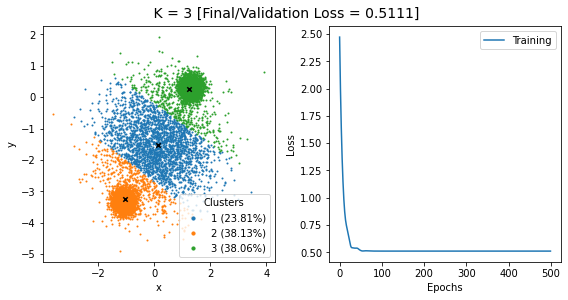

In [ ]:
fulldata_Mu_k_3, fulldata_k_3_loss_history = kmeans_tf2([X2D], K=3)
plot2D_kmeans_clusters_and_loss(X2D, fulldata_Mu_k_3, fulldata_k_3_loss_history)

Now, we will hold out a third of the data (at random) while training and use it for validation over $K=1,2,3,4,5$.

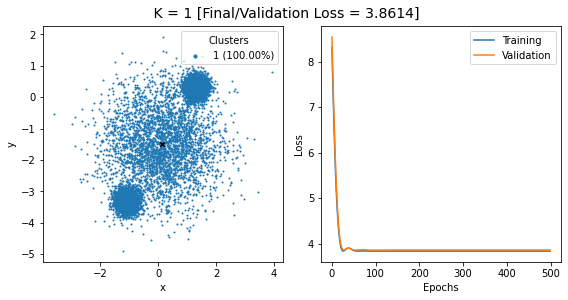

In [ ]:
Mu_k_1, validation_k_1_loss_history = kmeans_tf2([X2D_train, X2D_valid], K=1)
plot2D_kmeans_clusters_and_loss(X2D, Mu_k_1, validation_k_1_loss_history)

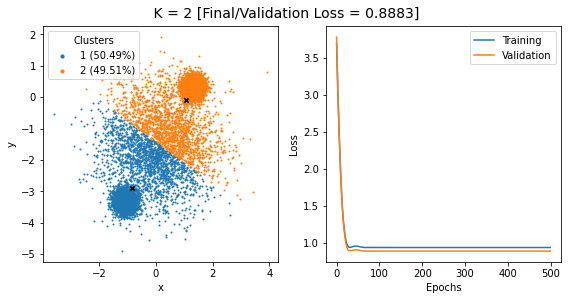

In [ ]:
Mu_k_2, validation_k_2_loss_history = kmeans_tf2([X2D_train, X2D_valid], K=2)
plot2D_kmeans_clusters_and_loss(X2D, Mu_k_2, validation_k_2_loss_history)

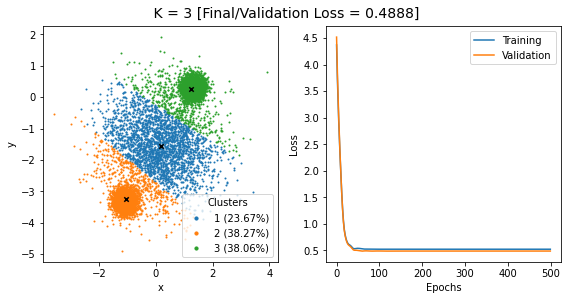

In [ ]:
Mu_k_3, validation_k_3_loss_history = kmeans_tf2([X2D_train, X2D_valid], K=3)
plot2D_kmeans_clusters_and_loss(X2D, Mu_k_3, validation_k_3_loss_history)

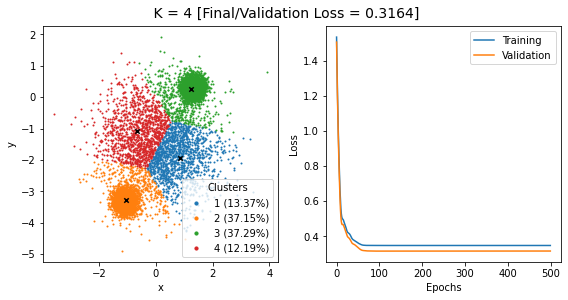

In [ ]:
Mu_k_4, validation_k_4_loss_history = kmeans_tf2([X2D_train, X2D_valid], K=4)
plot2D_kmeans_clusters_and_loss(X2D, Mu_k_4, validation_k_4_loss_history)

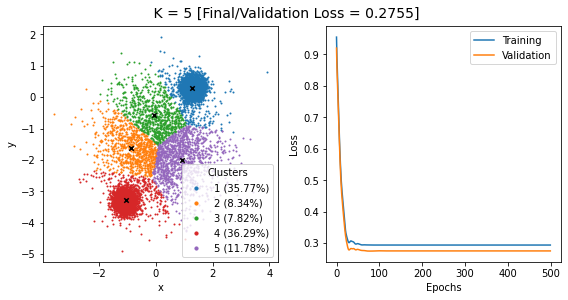

In [ ]:
Mu_k_5, validation_k_5_loss_history = kmeans_tf2([X2D_train, X2D_valid], K=5)
plot2D_kmeans_clusters_and_loss(X2D, Mu_k_5, validation_k_5_loss_history)

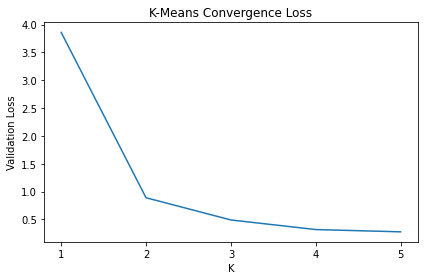

In [ ]:
# plot converged loss over K
plt.xticks([1, 2, 3, 4, 5])
plt.plot([1, 2, 3, 4, 5], 
         [validation_k_1_loss_history.flatten()[-1], validation_k_2_loss_history.flatten()[-1], 
         validation_k_3_loss_history.flatten()[-1], validation_k_4_loss_history.flatten()[-1],
         validation_k_5_loss_history.flatten()[-1]])
plt.title("K-Means Convergence Loss")
plt.xlabel("K")
plt.ylabel("Validation Loss")
plt.tight_layout()

As it is visible, the loss can artifically, albeit slowly, decrease as we increase the number of clusters (since the centers can be the same as inidividual points in the limiting case of $K=N$ resulting in zero loss). However, from looking at the final validation losses for each case in the plot above, it is clear that the decrease step in loss becomes visibly smaller as $K>3$. Also, from the datavector plots it is evident that there are three distinct clusters, and hence the loss is slowly (and artificially) decreasing beyond $K=3$, which acts as the "elbow" point, and is hence the optimal value for $K$.

## 2. Gaussian Mixture Models (GMMs)

We will now use a generative modelling technique to infer the cluster parameters for the dataset. Specifically, we employ GMMs which can be expressed using the following generative process given a probability/weight vector for each cluster, $\boldsymbol{\pi}\in[0,1]^K$, we write

$$z \sim \text{Categorical}(\boldsymbol{\pi})$$
$$\mathbf{x} \sim \mathcal{N}(\boldsymbol{\mu}_z, \boldsymbol{\Sigma}_z)$$

which define the mixture model as the probability density function (pdf) for observing a datavector $\mathbf{x}\in\mathbb{R}^d$ as

$$p_{\Omega}(\mathbf{x}) = \sum_{k=1}^K\pi_k\underbrace{\mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)}_{p_{\Omega}(\mathbf{x}\mid z= k)},$$

where $\Omega = \big\{\pi_k, \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k\big\}_{k=1}^K$ are the model parameters that we will optimize using gradient descent on the loss function.

### 2.1 Gaussian Cluster Mode

Given the model parameters $\Omega$, we assume the individual Gaussian clusters (called modes since we add each one's "components") to have uncorrelated axes with covariance $\boldsymbol{\Sigma}_k = \sigma_k^2\mathbf{I}$ (equal variance per axis). Thus, the multivariate Gaussian pdf becomes

$$p_{\Omega}(\mathbf{x}\mid z=k) = \mathcal{N}(\mathbf{x}; \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k) = \frac{\exp\left(\frac{-(\mathbf{x}-\boldsymbol{\mu}_k)^\top(\mathbf{x}-\boldsymbol{\mu}_k)}{2\sigma^2_k}\right)}{(2\pi\sigma_k^2)^\frac{d}{2}}$$

Since the joint probability is given by,
$$p_{\Omega}(\mathbf{x},z=k) = p_{\Omega}(\mathbf{x}\mid z=k)\cdot p_{\Omega}(z=k) = \pi_k \cdot p_{\Omega}(\mathbf{x}\mid z=k),$$

the posterior probability becomes

$$p_{\Omega}(z=k\mid\mathbf{x}) = \frac{p_{\Omega}(\mathbf{x},z=k)}{\sum_{i=1}^K p_{\Omega}(\mathbf{x},z=i)}.$$

For better numerical stability and performance in gradient descent, we will operate in the log probability domain. Thus, we define

$$\log p_{\Omega}(\mathbf{x}\mid z=k) = \frac{-(\mathbf{x}-\boldsymbol{\mu}_k)^\top(\mathbf{x}-\boldsymbol{\mu}_k)}{2\sigma^2_k} -\frac{d}{2}\log 2\pi\sigma_k^2$$

and

$$\log p_{\Omega}(z=k\mid\mathbf{x}) = \log p_{\Omega}(\mathbf{x}\mid z=k) + \log \pi_k - \log \sum_{i=1}^{K} \exp\left(\log p_{\Omega}(\mathbf{x}\mid z=i) + \log \pi_i\right)$$

We define the `reduce_logsumexp` and `logsoftmax` helper functions to be able to use perform the following operations while ensuring numerical stability as well as allow optimization in the probability space over an unconstrained variable using the softmax output. Since operations involving exponentiation of large values (due to the log operation) can result in under- or over-flow, these helper functions employ the following `logsumexp` trick to circumvent such issues. Considering an arbitrary vector $\mathbf{x}\in\mathbb{R}^d$, the quantity

$$\begin{align*}
y &= \log \sum_{i=1}^d \exp(x_i)\\
&= \log\left( e^c\sum_{i=1}^d \exp(x_i-c)\right)\\
&= c + \log\sum_{i=1}^d\exp(x_i-c),
\end{align*}$$

ensures numerical stability of the `logsumexp` operation by taking $c = \max\{x_1, \ldots, x_d\}$.

In [ ]:
# computes the sum of elements across dimensions of a tensor
def reduce_logsumexp(input_tensor, reduction_indices=1, keep_dims=False):
    # input_tensor: numeric tensor that is to be reduced
    # reduction_indices: the dimension along which to reduce
    # keep_dims: if true, retains reduced dimension with length 1
    # returns: the reduced tensor
    max_input_tensor1 = tf2.math.reduce_max(input_tensor, reduction_indices, keepdims=keep_dims)
    max_input_tensor2 = max_input_tensor1
    if not keep_dims:
        max_input_tensor2 = tf2.expand_dims(max_input_tensor2, reduction_indices)
    return tf2.math.log(tf2.math.reduce_sum(
                    tf2.math.exp(input_tensor - max_input_tensor2), 
                    reduction_indices, 
                    keepdims=keep_dims)) + max_input_tensor1

In [ ]:
# computes log(softmax) along the dimension of input (vector) tensor to return log probabilities
def logsoftmax(input_tensor):
  return input_tensor - reduce_logsumexp(input_tensor, reduction_indices=0, keep_dims=True)

In [ ]:
def log_gaussian_pdf(X, Mu, vars):
    # X:      N,D tensor
    # Mu:     K,D tensor
    # vars:   K,1 tensor of scalar variances of each cluster
    # return: N,K tensor with pairwise log probabilities of samples per cluster
    X_Mu_ks = pairwise_sq_dist(X, Mu)
    var_ks  = tf2.squeeze(vars)
    return -(1/2)*(X_Mu_ks/(2*var_ks) + X.shape[1]*tf2.math.log(2*np.pi*var_ks))

In [ ]:
def log_posterior(log_pdf, log_pi):
    # log_pdf: N,K tensor of pairwise evaluation of cluster pdfs over samples
    # log_pi:  K,1 tensor of cluster log probabilities
    # return:  N,K tensor of posterior log probabilities
    log_joint_probs = log_pdf + tf2.transpose(log_pi)
    return log_joint_probs - reduce_logsumexp(log_joint_probs, keep_dims=True)

To evaluate the quality of our generative model using Guassian mixtures, we utilize the negative log likelihood loss

$$E_{\text{in}}(\Omega) = -\frac{1}{N}\sum_{i=1}^N\log\sum_{k=1}^{K} \exp\left(\log p_{\Omega}(\mathbf{x}_i\mid z=k) + \log \pi_k\right).$$

Furthermore, to infer the cluster membership of a particular datavector, we use the following rule

$$\arg\max_k p_{\Omega}(z=k\mid\mathbf{x}_n),$$
for $n=1,\ldots,N$.

In [ ]:
def neg_log_likelihood_loss(X, Mu, phi, psi):
    vars    = tf2.math.exp(phi)
    log_pi  = logsoftmax(psi)
    log_pdf = log_gaussian_pdf(X, Mu, vars)
    return -tf2.math.reduce_mean(reduce_logsumexp(log_pdf + tf2.transpose(log_pi)))

In [ ]:
def assign_gmm_clusters(X, Mu, phi, psi):
    # X:      N,D numpy ndarray
    # Mu:     K,D numpy ndarray
    # phi:    K,1 numpy ndarray that defines cluster variances
    # psi:    K,1 numpy ndarray that defines cluster probabilities
    # return: N,1 array in {1,...,K}^N containing cluster assignment per sample
    vars    = tf2.math.exp(tf2.convert_to_tensor(phi))
    log_pdf = log_gaussian_pdf(tf2.convert_to_tensor(X), tf2.convert_to_tensor(Mu), vars)
    log_pi  = logsoftmax(tf2.convert_to_tensor(psi))
    pair_posterior_probs = log_posterior(log_pdf, log_pi)
    return tf2.argmax(pair_posterior_probs, axis=1).numpy()

### 2.2 Learning GMMs

Similar to $K$-means, we now train GMMs using the ADAM optimizer (gradient descent) over the negative log likelihood loss. Here, as the initial guess for the cluster centers, we default to using the output of the $K$-means algorithm.

In [ ]:
def gmm_tf2(Xs, K=1, epochs=500, initial_mu="kmeans"):
    # Xs: [X_train, X_valid (optional)]
    loss_hist = np.empty((0,len(Xs)), float)

    # convert datasets to tensors
    for i in range(len(Xs)):
        Xs[i] = tf2.convert_to_tensor(Xs[i], dtype=tf2.float64)
    
    # initialize Mu (K,D)
    if initial_mu == "kmeans":
        Mu,_ = kmeans_tf2(Xs, K=K)
        Mu   = tf2.Variable(initial_value=tf2.convert_to_tensor(Mu, dtype=tf2.float64))
    elif initial_mu == "mean":
        Mu = tf2.Variable(initial_value=tf2.random.normal([K, Xs[0].shape[1]], 
                                                          mean=tf2.math.reduce_mean(Xs[0], axis=0),
                                                          stddev=tf2.math.reduce_std(Xs[0], axis=0),
                                                          dtype=tf2.float64))

    # initialize phi and psi
    phi = tf2.Variable(initial_value=tf2.zeros([K, 1], dtype=tf2.float64))
    psi = tf2.Variable(initial_value=tf2.ones([K, 1], dtype=tf2.float64))

    # initialize ADAM optimizer
    optimizer = tf2.keras.optimizers.Adam(learning_rate=0.1, beta_1=0.9, beta_2=0.99, epsilon=1e-5)

    for _ in range(epochs):
        # gradient descent step
        with tf2.GradientTape() as tape:
            tape.watch([Mu, phi, psi])
            train_loss = neg_log_likelihood_loss(Xs[0], Mu, phi, psi)
        grads = tape.gradient(train_loss, [Mu, phi, psi])
        optimizer.apply_gradients(zip(grads, [Mu, phi, psi]))

        # update loss histories
        loss_hist = np.append(loss_hist, [[neg_log_likelihood_loss(Xs[i], Mu, phi, psi) 
                                            for i in range(len(Xs))]], axis=0)

    return Mu.numpy(), phi.numpy(), psi.numpy(), loss_hist

In [ ]:
def plot2D_gmm_clusters_and_loss(X2D, Mu, phi, psi, loss_hist, title=""):
    # loss_hist: [train_loss, valid_loss]
    f, ax = plt.subplots(1, 2, figsize=(8,4)) # clusters on left, loss on right
    
    assigned_clusters   = assign_gmm_clusters(X2D, Mu, phi, psi)
    cluster_percentages = [str(k+1)+" ("+"{:.2f}".format(100*np.mean(assigned_clusters==k))+"%)" 
                           for k in range(Mu.shape[0])]
    for k in range(Mu.shape[0]):
        idxs = assigned_clusters == k
        ax[0].scatter(X2D[idxs,0], X2D[idxs,1], s=1, label=cluster_percentages[k])
    ax0legend = ax[0].legend(title="Clusters")
    for handle in ax0legend.legendHandles:
        handle.set_sizes([10.0])
    ax[0].scatter(Mu[:,0], Mu[:,1], s=20, marker='x', c='k')
    
    labels = ["Training", "Validation"]
    for i in range(loss_hist.shape[1]):
        ax[1].plot(loss_hist[:, i], label=labels[i])
    
    # add axes lables and title
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    plt.suptitle(title+" K = "+str(Mu.shape[0])+" [Final/Validation Loss = "+
                 "{:.4f}".format(loss_hist.flatten()[-1])+"]", fontsize=14, y=1.03)
    return plt.tight_layout()

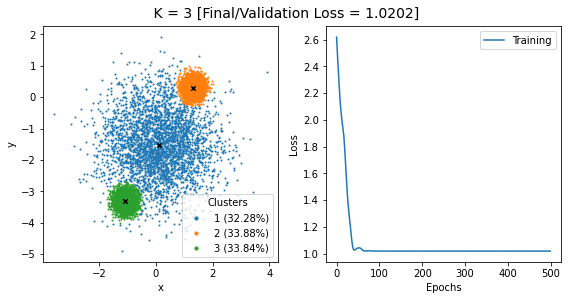

In [ ]:
fullgmm_Mu_k_3, fullgmm_phi_k_3, fullgmm_psi_k_3, fullgmm_k_3_loss_history = gmm_tf2([X2D], K=3)
plot2D_gmm_clusters_and_loss(X2D, fullgmm_Mu_k_3, fullgmm_phi_k_3, fullgmm_psi_k_3, fullgmm_k_3_loss_history)

In [ ]:
fullgmm_Mu_k_3 # cluster centers (x,y)

array([[ 0.10720156, -1.52881977],
       [ 1.30361539,  0.30655584],
       [-1.10112369, -3.30495788]])

In [ ]:
np.exp(fullgmm_phi_k_3) # cluster variances

array([[0.49293041],
       [0.01944053],
       [0.01954295]])

In [ ]:
np.exp(fullgmm_psi_k_3)/sum(np.exp(fullgmm_psi_k_3)) # cluster membership shares

array([[0.33466817],
       [0.33345791],
       [0.33187392]])

Now, we will hold out a third of the data (at random) while training and use it for validation over $K=1,2,3,4,5$.

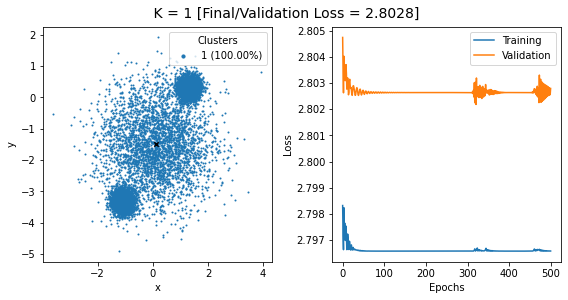

In [ ]:
gmm_Mu_k_1, gmm_phi_k_1, gmm_psi_k_1, gmm_valid_k_1_loss = gmm_tf2([X2D_train, X2D_valid], K=1)
plot2D_gmm_clusters_and_loss(X2D, gmm_Mu_k_1, gmm_phi_k_1, gmm_psi_k_1, gmm_valid_k_1_loss)

Note above, since we start from $K$-means, we will essentially be starting from the best guess possible for $K=1$, and hence the gradient descent search converges back to where it started, and this is also why the validation and training losses are close to each other.

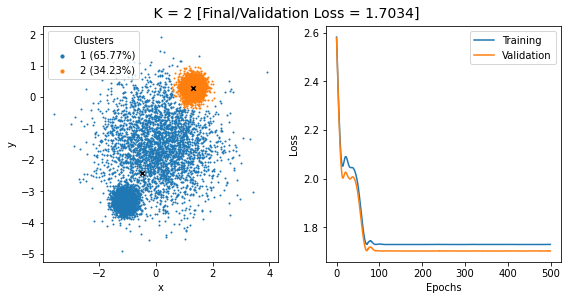

In [ ]:
gmm_Mu_k_2, gmm_phi_k_2, gmm_psi_k_2, gmm_valid_k_2_loss = gmm_tf2([X2D_train, X2D_valid], K=2)
plot2D_gmm_clusters_and_loss(X2D, gmm_Mu_k_2, gmm_phi_k_2, gmm_psi_k_2, gmm_valid_k_2_loss)

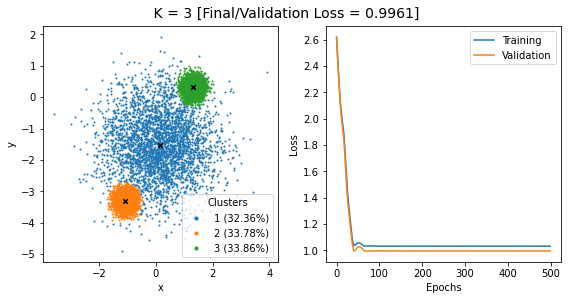

In [ ]:
gmm_Mu_k_3, gmm_phi_k_3, gmm_psi_k_3, gmm_valid_k_3_loss = gmm_tf2([X2D_train, X2D_valid], K=3)
plot2D_gmm_clusters_and_loss(X2D, gmm_Mu_k_3, gmm_phi_k_3, gmm_psi_k_3, gmm_valid_k_3_loss)

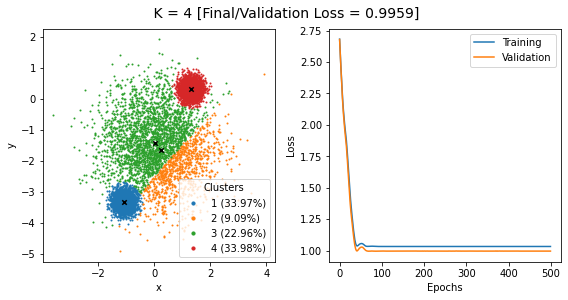

In [ ]:
gmm_Mu_k_4, gmm_phi_k_4, gmm_psi_k_4, gmm_valid_k_4_loss = gmm_tf2([X2D_train, X2D_valid], K=4)
plot2D_gmm_clusters_and_loss(X2D, gmm_Mu_k_4, gmm_phi_k_4, gmm_psi_k_4, gmm_valid_k_4_loss)

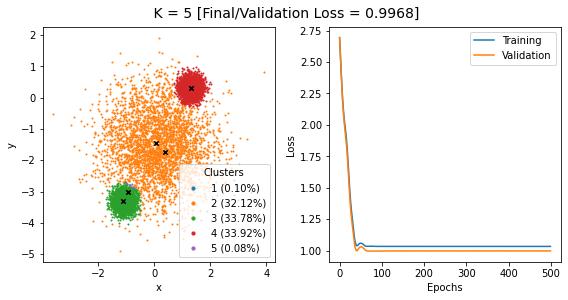

In [ ]:
gmm_Mu_k_5, gmm_phi_k_5, gmm_psi_k_5, gmm_valid_k_5_loss = gmm_tf2([X2D_train, X2D_valid], K=5)
plot2D_gmm_clusters_and_loss(X2D, gmm_Mu_k_5, gmm_phi_k_5, gmm_psi_k_5, gmm_valid_k_5_loss)

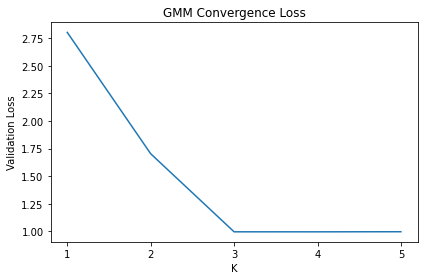

In [ ]:
# plot converged loss over K
plt.xticks([1, 2, 3, 4, 5])
plt.plot([1, 2, 3, 4, 5], 
         [gmm_valid_k_1_loss.flatten()[-1], gmm_valid_k_2_loss.flatten()[-1], 
         gmm_valid_k_3_loss.flatten()[-1], gmm_valid_k_4_loss.flatten()[-1],
         gmm_valid_k_5_loss.flatten()[-1]])
plt.title("GMM Convergence Loss")
plt.xlabel("K")
plt.ylabel("Validation Loss")
plt.tight_layout()

optimal value

### 2.3 Comparing $K$-means and GMMs


In [ ]:
_, kmeans_valid_100D_k_5_loss  = kmeans_tf2([X100D_train, X100D_valid], K=5)
_, kmeans_valid_100D_k_10_loss = kmeans_tf2([X100D_train, X100D_valid], K=10)
_, kmeans_valid_100D_k_15_loss = kmeans_tf2([X100D_train, X100D_valid], K=15)
_, kmeans_valid_100D_k_20_loss = kmeans_tf2([X100D_train, X100D_valid], K=20)
_, kmeans_valid_100D_k_30_loss = kmeans_tf2([X100D_train, X100D_valid], K=30)

In [ ]:
_, _, _, gmm_valid_100D_k_5_loss  = gmm_tf2([X100D_train, X100D_valid], K=5)
_, _, _, gmm_valid_100D_k_10_loss = gmm_tf2([X100D_train, X100D_valid], K=10)
_, _, _, gmm_valid_100D_k_15_loss = gmm_tf2([X100D_train, X100D_valid], K=15)
_, _, _, gmm_valid_100D_k_20_loss = gmm_tf2([X100D_train, X100D_valid], K=20)
_, _, _, gmm_valid_100D_k_30_loss = gmm_tf2([X100D_train, X100D_valid], K=30)

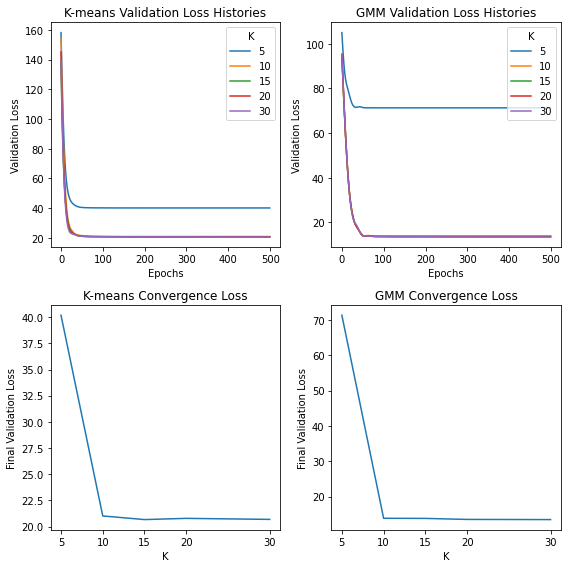

In [ ]:
# validation losses for K-means on left and GMM on right
f, ax = plt.subplots(2, 2, figsize=(8,8))
ax[0,0].plot(kmeans_valid_100D_k_5_loss[:,1], label="5")
ax[0,0].plot(kmeans_valid_100D_k_10_loss[:,1], label="10")
ax[0,0].plot(kmeans_valid_100D_k_15_loss[:,1], label="15")
ax[0,0].plot(kmeans_valid_100D_k_20_loss[:,1], label="20")
ax[0,0].plot(kmeans_valid_100D_k_30_loss[:,1], label="30")
ax[0,1].plot(gmm_valid_100D_k_5_loss[:,1], label="5")
ax[0,1].plot(gmm_valid_100D_k_10_loss[:,1], label="10")
ax[0,1].plot(gmm_valid_100D_k_15_loss[:,1], label="15")
ax[0,1].plot(gmm_valid_100D_k_20_loss[:,1], label="20")
ax[0,1].plot(gmm_valid_100D_k_30_loss[:,1], label="30")
ax[0,0].legend(title="K")
ax[0,1].legend(title="K")
ax[1,0].set_xticks([5, 10, 15, 20, 30])
ax[1,0].plot([5, 10, 15, 20, 30], 
         [kmeans_valid_100D_k_5_loss.flatten()[-1], kmeans_valid_100D_k_10_loss.flatten()[-1], 
         kmeans_valid_100D_k_15_loss.flatten()[-1], kmeans_valid_100D_k_20_loss.flatten()[-1],
         kmeans_valid_100D_k_30_loss.flatten()[-1]])
ax[1,1].set_xticks([5, 10, 15, 20, 30])
ax[1,1].plot([5, 10, 15, 20, 30], 
         [gmm_valid_100D_k_5_loss.flatten()[-1], gmm_valid_100D_k_10_loss.flatten()[-1], 
         gmm_valid_100D_k_15_loss.flatten()[-1], gmm_valid_100D_k_20_loss.flatten()[-1],
         gmm_valid_100D_k_30_loss.flatten()[-1]])

# add axes lables and title
ax[0,0].set_title("K-means Validation Loss Histories")
ax[0,0].set_xlabel("Epochs")
ax[0,0].set_ylabel("Validation Loss")
ax[0,1].set_title("GMM Validation Loss Histories")
ax[0,1].set_xlabel("Epochs")
ax[0,1].set_ylabel("Validation Loss")
ax[1,0].set_title("K-means Convergence Loss")
ax[1,0].set_xlabel("K")
ax[1,0].set_ylabel("Final Validation Loss")
ax[1,1].set_title("GMM Convergence Loss")
ax[1,1].set_xlabel("K")
ax[1,1].set_ylabel("Final Validation Loss")
plt.tight_layout()

In [ ]:
gmm_valid_100D_k_10_loss.flatten()[-1]

13.49275052395318